In [182]:
import os
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np
import requests
import regex as re
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sns

In [116]:
stemmer = SnowballStemmer('spanish')

In [117]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\57320\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [118]:
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57320\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
stopwords_es_list = list(stopwords_es)

In [120]:
os.makedirs('pos', exist_ok=True)
os.makedirs('neg', exist_ok=True)

In [121]:
# URL para descargar el XML
url = "http://tass.sepln.org/tass_data/dataset/general-train-tagged-3l.xml"
response = requests.get(url)

# Parsear el contenido XML
root = ET.fromstring(response.content)

tweets_data = []
for tweet in root.findall('tweet'):
    tweetid = tweet.find('tweetid').text
    user = tweet.find('user').text
    content_element = tweet.find('content')
    content = content_element.text.strip() if content_element is not None and content_element.text is not None else None
    date = tweet.find('date').text
    lang = tweet.find('lang').text
    sentiment = tweet.find('sentiments/polarity/value').text if tweet.find('sentiments/polarity/value') is not None else None

    tweets_data.append({
        'tweetid': tweetid,
        'user': user,
        'content': content,
        'date': date,
        'lang': lang,
        'sentiment': sentiment
    })

# Crear un DataFrame
df_train = pd.DataFrame(tweets_data)

In [122]:
df_train

,tweetid,user,content,date,lang,sentiment
0,142389495503925248,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE
1,142389933619945473,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU
2,142391947707940864,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P
3,142416095012339712,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N
4,142422495721562112,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P
...,...,...,...,...,...,...
7214,189809904935120896,mariviromero,Muy indignante si ...nadie repara en ello hoy ...,2012-04-10T22:19:42,es,N
7215,189814854503235584,mariviromero,Más pobres por discriminar a la mujer http://t...,2012-04-10T22:39:22,es,N
7216,189815389021143041,mariviromero,Crean un banco de productos para mujeres con c...,2012-04-10T22:41:30,es,P
7217,189824278827507712,Tonicanto1,Sobre la sorprendente huída hoy en el Senado d...,2012-04-10T23:16:49,es,N


In [123]:
df_train.groupby("sentiment").count()

,tweetid,user,content,date,lang
sentiment,,,,,
N,2182,2182,2182,2182,2182
NEU,670,670,670,670,670
NONE,1483,1483,1482,1483,1483
P,2884,2884,2884,2884,2884


In [124]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET

url = "http://tass.sepln.org/tass_data/dataset/general-test-tagged-3l.xml"
response = requests.get(url)

# Parsear el contenido XML
root = ET.fromstring(response.content)

tweets_data = []
for tweet in root.findall('tweet'):
    tweetid = tweet.find('tweetid').text
    user = tweet.find('user').text
    content = tweet.find('content').text.strip() if tweet.find('content') is not None else None
    date = tweet.find('date').text
    lang = tweet.find('lang').text
    sentiment = tweet.find('sentiments/polarity/value').text if tweet.find('sentiments/polarity/value') is not None else None
    
    tweets_data.append({
        'tweetid': tweetid,
        'user': user,
        'content': content,
        'date': date,
        'lang': lang,
        'sentiment': sentiment
    })

df_test = pd.DataFrame(tweets_data)

In [125]:
df_test

,tweetid,user,content,date,lang,sentiment
0,142378325086715906,jesusmarana,"Portada 'Público', viernes. Fabra al banquillo...",2011-12-02T00:03:32,es,N
1,142379080808013825,EvaORegan,"Grande! RT @veronicacalderon ""El periodista es...",2011-12-02T00:06:32,es,NONE
2,142379173120442368,LosadaPescador,Gonzalo Altozano tras la presentación de su li...,2011-12-02T00:06:55,es,P
3,142379815708803072,mgilguerrero,"Mañana en Gaceta: TVE, la que pagamos tú y yo,...",2011-12-02T00:09:28,es,N
4,142381190123499520,pedroj_ramirez,Qué envidia “@mfcastineiras: Pedro mañana x la...,2011-12-02T00:14:55,es,NONE
...,...,...,...,...,...,...
60793,189828399030747136,sanchez_sonia,@Juandecolmenero @angelrubioti @barbara_ruizp ...,2012-04-10T23:33:11,es,P
60794,189828787582664704,Albert_Rivera,Escuchan lo que quieren RT @almudenanegro: El ...,2012-04-10T23:34:44,es,NONE
60795,189830088437665792,BelenHoyo,¿A qué espera el alcalde promarihuana independ...,2012-04-10T23:39:54,es,N
60796,189831045846274049,Albert_Rivera,Esto es lo que hay... Preocupante la flagrante...,2012-04-10T23:43:42,es,N


In [126]:
df_test.groupby("sentiment").count()

,tweetid,user,content,date,lang
sentiment,,,,,
N,15844,15844,15844,15844,15844
NEU,1305,1305,1305,1305,1305
NONE,21416,21416,21416,21416,21416
P,22233,22233,22233,22233,22233


In [127]:
corpus = pd.concat([df_train, df_test]).reset_index(drop=True)

In [128]:
corpus

,tweetid,user,content,date,lang,sentiment
0,142389495503925248,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE
1,142389933619945473,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU
2,142391947707940864,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P
3,142416095012339712,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N
4,142422495721562112,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P
...,...,...,...,...,...,...
68012,189828399030747136,sanchez_sonia,@Juandecolmenero @angelrubioti @barbara_ruizp ...,2012-04-10T23:33:11,es,P
68013,189828787582664704,Albert_Rivera,Escuchan lo que quieren RT @almudenanegro: El ...,2012-04-10T23:34:44,es,NONE
68014,189830088437665792,BelenHoyo,¿A qué espera el alcalde promarihuana independ...,2012-04-10T23:39:54,es,N
68015,189831045846274049,Albert_Rivera,Esto es lo que hay... Preocupante la flagrante...,2012-04-10T23:43:42,es,N


In [129]:
corpus_filtrado = corpus[(corpus["sentiment"] == "P") | (corpus["sentiment"] == "N")].reset_index(drop=True)

In [130]:
corpus_filtrado.groupby("sentiment").count()

,tweetid,user,content,date,lang
sentiment,,,,,
N,18026,18026,18026,18026,18026
P,25117,25117,25117,25117,25117


In [131]:
pos_data = corpus_filtrado[corpus_filtrado['sentiment'] == 'P']
neg_data = corpus_filtrado[corpus_filtrado['sentiment'] == 'N']

In [132]:
pos_sample = pos_data.sample(frac=0.2, random_state=42)
neg_sample = neg_data.sample(frac=0.2, random_state=42)

In [133]:
sample_size = min(len(pos_sample), len(neg_sample))
pos_sample = pos_sample.sample(n=sample_size, random_state=2024)
neg_sample = neg_sample.sample(n=sample_size, random_state=2024)

In [134]:
pos_sample.head()

,tweetid,user,content,date,lang,sentiment
17714,158509628945203201,mariviromero,Comienza Soraya su intervención comentando que...,2012-01-15T12:23:35,es,P
21146,162573463356313601,pedroj_ramirez,Qué buen título para esta crónica pero ¿será o...,2012-01-26T17:31:48,es,P
15055,155225961179254784,DiegoMazon78,"Me voy a la #pascuamilitar. Si,me he fumado la...",2012-01-06T10:55:27,es,P
6003,143739090305695744,JAMonago,buena “@aariasdominguez: Estoy convencido: mir...,2011-12-05T18:10:44,es,P
14399,154327548464087040,pedroj_ramirez,Lina es maravillosa “@martalmela: sabes q mi m...,2012-01-03T23:25:29,es,P


In [135]:
neg_sample.head()

,tweetid,user,content,date,lang,sentiment
3015,170626108616749056,santiagocervera,No me he debido expresar bien en @hora25. Inte...,2012-02-17T22:50:09,es,N
42595,189266695049854977,iescolar,En el blog: La sanidad pasa de intocable a ins...,2012-04-09T10:21:11,es,N
35181,179485098951966721,PilarGGranja,"El ministro @jmsoria habla de Industria : ""el ...",2012-03-13T09:32:36,es,N
1189,154194246931464192,pedroj_ramirez,Algo hemos avanzado “@JJCarmorenilla: ¿Puede v...,2012-01-03T14:35:47,es,N
32401,175662890941038592,estherpalomera,"En el congreso del @psm. Viejos recuerdos, dam...",2012-03-02T20:24:31,es,N


In [136]:
def save_to_txt(data, folder):
    for index, row in data.iterrows():
        filename = f"{folder}/{index}.txt"
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(row['content'])

save_to_txt(pos_sample, 'pos')
save_to_txt(neg_sample, 'neg')

In [137]:
print(f"Se generaron {len(pos_sample)} archivos en 'pos' y {len(neg_sample)} archivos en 'neg'.")

Se generaron 3605 archivos en 'pos' y 3605 archivos en 'neg'.


In [138]:
def count_words_in_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
        return len(content.split())

def get_word_counts(folder):
    filepaths = [os.path.join(folder, filename) for filename in os.listdir(folder)]
    return [count_words_in_file(filepath) for filepath in filepaths]

In [139]:
def calculate_metrics(word_counts):
    metrics = {
        "Mean": np.mean(word_counts),
        "Std": np.std(word_counts),
        "Min": np.min(word_counts),
        "Max": np.max(word_counts),
        "25%": np.percentile(word_counts, 25),
        "50%": np.percentile(word_counts, 50),
        "75%": np.percentile(word_counts, 75),
        "Sum": np.sum(word_counts)
    }
    return metrics

In [140]:
pos_word_counts = get_word_counts('pos')
neg_word_counts = get_word_counts('neg')
all_word_counts = pos_word_counts + neg_word_counts

In [141]:
pos_metrics = calculate_metrics(pos_word_counts)
neg_metrics = calculate_metrics(neg_word_counts)
combined_metrics = calculate_metrics(all_word_counts)

In [142]:
metrics_df = pd.DataFrame([pos_metrics, neg_metrics, combined_metrics], index=["pos", "neg", "combined"])

In [143]:
metrics_df

,Mean,Std,Min,Max,25%,50%,75%,Sum
pos,16.527046,5.718661,1,32,13.0,17.0,21.0,59580
neg,19.027184,4.900829,2,31,16.0,20.0,23.0,68593
combined,17.777115,5.470217,1,32,14.0,18.0,22.0,128173


In [144]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'[áéíóú]', lambda x: {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u'}[x.group()], text)

    text = re.sub(r'\d+', '', text)

    text = re.sub(r'http\S+|www\.\S+', '', text)

    text = text.replace('\n', ' ').replace('\r', ' ')

    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    return text

def process_folder(folder):
    filepaths = [os.path.join(folder, filename) for filename in os.listdir(folder) if filename.endswith('.txt')]
    for filepath in filepaths:
        with open(filepath, 'r', encoding='utf-8') as file:
            original_text = file.read()
        cleaned_text = clean_text(original_text)
        with open(filepath, 'w', encoding='utf-8') as file:
            file.write(cleaned_text)

process_folder('pos')
process_folder('neg')

print("Todos los archivos en las carpetas 'pos' y 'neg' han sido procesados y limpiados.")

Todos los archivos en las carpetas 'pos' y 'neg' han sido procesados y limpiados.


In [145]:
def leer_y_tokenizar(carpeta):
    textos_tokenizados = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith('.txt'):
            ruta_archivo = os.path.join(carpeta, archivo)
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                texto = f.read()
                # Tokenizar el texto
                tokens = word_tokenize(texto)
                textos_tokenizados[archivo] = tokens
    return textos_tokenizados

In [146]:
def cargar_textos(carpeta):
    textos = []
    for archivo in os.listdir(carpeta):
        if archivo.endswith('.txt'):  
            ruta_archivo = os.path.join(carpeta, archivo)
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                texto = f.read()
                textos.append(texto)
    return textos

In [147]:
carpeta_pos = 'pos'
carpeta_neg = 'neg'

textos_pos = cargar_textos(carpeta_pos)
textos_neg = cargar_textos(carpeta_neg)

corpus = textos_pos + textos_neg

In [148]:
y = np.array([1] * len(textos_pos) + [0] * len(textos_neg))

In [149]:
vectorizer = CountVectorizer(ngram_range=(1, 2))  
X_to = vectorizer.fit_transform(corpus) 

print("Características del BoW (vocabulario):")
print(vectorizer.get_feature_names_out())

print("\nMatriz de características BoW (Term Occurrence - TO):")
print(X_to.toarray())

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_to)

print("\nMatriz de características ponderada por TF-IDF:")
print(X_tfidf.toarray())

Características del BoW (vocabulario):
['_aliflor_' '_aliflor_ ha' '_avt_' ... 'öffentlichen dienstes'
 'お元気ですかmuchos' 'お元気ですかmuchos besos']

Matriz de características BoW (Term Occurrence - TO):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Matriz de características ponderada por TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [150]:
vectorizer_preprocessed = CountVectorizer(
    ngram_range=(1, 2),        
    stop_words=stopwords_es_list,   
    min_df=3                   
)
X_stopwords = vectorizer_preprocessed.fit_transform(corpus)

X_to_stopwords = X_stopwords

print("\nVocabulario tras eliminación de stopwords y filtrado por frecuencia:")
print(vectorizer_preprocessed.get_feature_names_out())

print("\nMatriz de características BoW con preprocesamiento (Term Occurrence - TO):")
print(X_to_stopwords.toarray())

tfidf_transformer = TfidfTransformer()
X_tfidf_stopwords = tfidf_transformer.fit_transform(X_to_stopwords)

print("\nMatriz de características con preprocesamiento ponderada por TF-IDF:")
print(X_tfidf_stopwords.toarray())


Vocabulario tras eliminación de stopwords y filtrado por frecuencia:
['_rubalcaba_' 'aalvarezalvarez' 'aarbeloa' ... 'zonas' 'zougam' 'zp']

Matriz de características BoW con preprocesamiento (Term Occurrence - TO):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Matriz de características con preprocesamiento ponderada por TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [151]:
def aplicar_stemming(texto):
    tokens = texto.split()  
    tokens_stemmed = [stemmer.stem(token) for token in tokens]  
    return ' '.join(tokens_stemmed) 

In [152]:
corpus_stemmed = [aplicar_stemming(texto) for texto in corpus]

vectorizer_stemming = CountVectorizer(ngram_range=(1, 2))  
X_stemming = vectorizer_stemming.fit_transform(corpus_stemmed)

X_to_stemming = X_stemming

print("\nVocabulario del BoW con Stemming:")
print(vectorizer_stemming.get_feature_names_out())

print("\nMatriz de características BoW con Stemming (Term Occurrence - TO):")
print(X_to_stemming.toarray())

tfidf_transformer = TfidfTransformer()
X_tfidf_stemming = tfidf_transformer.fit_transform(X_to_stemming)

print("\nMatriz de características con Stemming ponderada por TF-IDF:")
print(X_tfidf_stemming.toarray())


Vocabulario del BoW con Stemming:
['_aliflor_' '_aliflor_ ha' '_avt_' ... 'öffentlich dienst' 'お元気ですかmuch'
 'お元気ですかmuch bes']

Matriz de características BoW con Stemming (Term Occurrence - TO):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Matriz de características con Stemming ponderada por TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [153]:
def preprocesar_texto(texto):
    tokens = texto.split()
    tokens_stemmed = [stemmer.stem(token) for token in tokens if token not in stopwords_es]
    return ' '.join(tokens_stemmed)

In [154]:
corpus_preprocessed = [preprocesar_texto(texto) for texto in corpus]

vectorizer_preprocessed = CountVectorizer(
    ngram_range=(1, 2),  
    min_df=3             
)
X_preprocessed = vectorizer_preprocessed.fit_transform(corpus_preprocessed)

X_to_preprocessed = X_preprocessed

print("\nVocabulario del BoW con Stemming + Stopwords + Frecuencia:")
print(vectorizer_preprocessed.get_feature_names_out())

print("\nMatriz de características BoW con Stemming + Stopwords + Frecuencia (Term Occurrence - TO):")
print(X_to_preprocessed.toarray())

tfidf_transformer = TfidfTransformer()
X_tfidf_preprocessed = tfidf_transformer.fit_transform(X_to_preprocessed)

print("\nMatriz de características con Stemming + Stopwords + Frecuencia ponderada por TF-IDF:")
print(X_tfidf_preprocessed.toarray())


Vocabulario del BoW con Stemming + Stopwords + Frecuencia:
['_rubalcaba_' 'aalvarezalvarez' 'aarbelo' ... 'zon recre' 'zougam' 'zp']

Matriz de características BoW con Stemming + Stopwords + Frecuencia (Term Occurrence - TO):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Matriz de características con Stemming + Stopwords + Frecuencia ponderada por TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Sin preprocesamiento

In [155]:
X_train_to, X_test_to, y_train, y_test = train_test_split(X_to, y, test_size=0.2, random_state=42)

X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#### Regresión Logística

In [156]:
logreg_to = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_to, X_train_to, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO):")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_to.fit(X_train_to, y_train)
y_pred_to = logreg_to.predict(X_test_to)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO):
F1 ponderado por Fold: [0.8353256  0.82479875 0.8387081  0.83707664 0.82842494 0.85258267
 0.83864016 0.82668249 0.84709321 0.85409628]
Promedio de F1 ponderado: 0.8383428843944147
Desviación Estándar de F1 ponderado: 0.009778611380521133

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8606524561866035
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       694
           1       0.87      0.85      0.86       748

    accuracy                           0.86      1442
   macro avg       0.86      0.86      0.86      1442
weighted avg       0.86      0.86      0.86      1442



In [157]:
logreg_tfidf = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_tfidf, X_train_tfidf, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf))


Resultados de Validación Cruzada (10-Fold) con TF-IDF:
F1 ponderado por Fold: [0.82630136 0.81772522 0.82456128 0.80402166 0.7970441  0.81931975
 0.82797624 0.81254332 0.85069804 0.83468306]
Promedio de F1 ponderado: 0.8214874027184382
Desviación Estándar de F1 ponderado: 0.014503417593262334

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8537166215846472
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       694
           1       0.88      0.83      0.86       748

    accuracy                           0.85      1442
   macro avg       0.85      0.85      0.85      1442
weighted avg       0.86      0.85      0.85      1442



#### Decision tree

In [158]:
tree_to = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_to, X_train_to, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Árbol de Decisión y Term Occurrence (TO):")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_to.fit(X_train_to, y_train)
y_pred_to = tree_to.predict(X_test_to)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to))


Resultados de Validación Cruzada (10-Fold) con Árbol de Decisión y Term Occurrence (TO):
F1 ponderado por Fold: [0.71878105 0.70507488 0.70876535 0.73283254 0.69141138 0.72424287
 0.72065663 0.69282002 0.73088087 0.74129839]
Promedio de F1 ponderado: 0.7166763979044612
Desviación Estándar de F1 ponderado: 0.01597241905649873

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7185452078286273
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71       694
           1       0.74      0.71      0.72       748

    accuracy                           0.72      1442
   macro avg       0.72      0.72      0.72      1442
weighted avg       0.72      0.72      0.72      1442



In [159]:
tree_tfidf = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_tfidf, X_train_tfidf, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Árbol de Decisión y TF-IDF:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = tree_tfidf.predict(X_test_tfidf)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf))


Resultados de Validación Cruzada (10-Fold) con Árbol de Decisión y TF-IDF:
F1 ponderado por Fold: [0.67938571 0.68796287 0.71055106 0.70330611 0.69654665 0.6464089
 0.70191178 0.71187215 0.71700792 0.68870431]
Promedio de F1 ponderado: 0.6943657465770429
Desviación Estándar de F1 ponderado: 0.019544933678615158

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.6976957286108663
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69       694
           1       0.71      0.70      0.71       748

    accuracy                           0.70      1442
   macro avg       0.70      0.70      0.70      1442
weighted avg       0.70      0.70      0.70      1442



#### K vecinos más cercanos

In [160]:
knn_to = KNeighborsClassifier(n_neighbors=5)

cv_scores = cross_val_score(knn_to, X_train_to, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con KNN y Term Occurrence (TO):")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_to.fit(X_train_to, y_train)
y_pred_to = knn_to.predict(X_test_to)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to))


Resultados de Validación Cruzada (10-Fold) con KNN y Term Occurrence (TO):
F1 ponderado por Fold: [0.39932836 0.40097923 0.4249618  0.40198668 0.40125138 0.37281043
 0.37909429 0.38303526 0.40446715 0.39810094]
Promedio de F1 ponderado: 0.3966015519552025
Desviación Estándar de F1 ponderado: 0.014149930911753579

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.4134468008643961
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.69      0.07      0.12       694
           1       0.53      0.97      0.68       748

    accuracy                           0.54      1442
   macro avg       0.61      0.52      0.40      1442
weighted avg       0.60      0.54      0.41      1442



In [ ]:
knn_tfidf = KNeighborsClassifier(n_neighbors=5)

cv_scores = cross_val_score(knn_tfidf, X_train_tfidf, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con KNN y TF-IDF:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = knn_tfidf.predict(X_test_tfidf)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf))


Resultados de Validación Cruzada (10-Fold) con KNN y TF-IDF:
F1 ponderado por Fold: [0.77643384 0.75731757 0.7461661  0.76430234 0.75888145 0.78508628
 0.77441609 0.78974873 0.77934966 0.76214776]
Promedio de F1 ponderado: 0.7693849827670334
Desviación Estándar de F1 ponderado: 0.013072031414300465

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7850952753075396
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       694
           1       0.80      0.78      0.79       748

    accuracy                           0.79      1442
   macro avg       0.78      0.79      0.78      1442
weighted avg       0.79      0.79      0.79      1442



## Stopwords

In [162]:
X_train_to_stopwords, X_test_to_stopwords, y_train, y_test = train_test_split(
    X_to_stopwords, y, test_size=0.2, random_state=42
)

# Dividir en conjuntos de entrenamiento y prueba para TF-IDF
X_train_tfidf_stopwords, X_test_tfidf_stopwords, _, _ = train_test_split(
    X_tfidf_stopwords, y, test_size=0.2, random_state=42
)

#### Logistic Regression

In [163]:
logreg_to_stopwords = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_to_stopwords, X_train_to_stopwords, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y eliminación de stopwords:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_to_stopwords.fit(X_train_to_stopwords, y_train)
y_pred_to_stopwords = logreg_to_stopwords.predict(X_test_to_stopwords)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_stopwords, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_stopwords))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y eliminación de stopwords:
F1 ponderado por Fold: [0.83010598 0.81451125 0.84736502 0.83015904 0.80936104 0.85437391
 0.83187696 0.83184665 0.85241854 0.85754612]
Promedio de F1 ponderado: 0.8359564504881776
Desviación Estándar de F1 ponderado: 0.015732308819759563

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8585777401539532
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       694
           1       0.87      0.85      0.86       748

    accuracy                           0.86      1442
   macro avg       0.86      0.86      0.86      1442
weighted avg       0.86      0.86      0.86      1442



In [ ]:
logreg_tfidf_stopwords = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_tfidf_stopwords, X_train_tfidf_stopwords, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF y eliminación de stopwords:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_tfidf_stopwords.fit(X_train_tfidf_stopwords, y_train)
y_pred_tfidf_stopwords = logreg_tfidf_stopwords.predict(X_test_tfidf_stopwords)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_stopwords, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_stopwords))


Resultados de Validación Cruzada (10-Fold) con TF-IDF y eliminación de stopwords:
F1 ponderado por Fold: [0.83530679 0.81577963 0.86101519 0.83165843 0.82304493 0.8541143
 0.84022042 0.81249027 0.8644067  0.85534123]
Promedio de F1 ponderado: 0.8393377894263354
Desviación Estándar de F1 ponderado: 0.017860709841992718

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8571681403769127
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       694
           1       0.89      0.83      0.86       748

    accuracy                           0.86      1442
   macro avg       0.86      0.86      0.86      1442
weighted avg       0.86      0.86      0.86      1442



#### Decision tree

In [ ]:
tree_to_stopwords = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_to_stopwords, X_train_to_stopwords, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y eliminación de stopwords:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_to_stopwords.fit(X_train_to_stopwords, y_train)
y_pred_to_stopwords = tree_to_stopwords.predict(X_test_to_stopwords)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_stopwords, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_stopwords))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y eliminación de stopwords:
F1 ponderado por Fold: [0.71558913 0.70668716 0.75316878 0.7280967  0.71864831 0.76127509
 0.74515437 0.75316878 0.71986014 0.78274917]
Promedio de F1 ponderado: 0.7384397622384167
Desviación Estándar de F1 ponderado: 0.023104137713269128

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7574061602631524
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73       694
           1       0.74      0.84      0.78       748

    accuracy                           0.76      1442
   macro avg       0.76      0.76      0.76      1442
weighted avg       0.76      0.76      0.76      1442



In [ ]:
tree_tfidf_stopwords = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_tfidf_stopwords, X_train_tfidf_stopwords, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF y eliminación de stopwords:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_tfidf_stopwords.fit(X_train_tfidf_stopwords, y_train)
y_pred_tfidf_stopwords = tree_tfidf_stopwords.predict(X_test_tfidf_stopwords)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_stopwords, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_stopwords))


Resultados de Validación Cruzada (10-Fold) con TF-IDF y eliminación de stopwords:
F1 ponderado por Fold: [0.70559479 0.70593511 0.77110952 0.70035366 0.71930731 0.74611643
 0.73989718 0.74578112 0.73602269 0.76809482]
Promedio de F1 ponderado: 0.7338212640693375
Desviación Estándar de F1 ponderado: 0.024095995141573144

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7630390145891854
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       694
           1       0.75      0.82      0.78       748

    accuracy                           0.76      1442
   macro avg       0.77      0.76      0.76      1442
weighted avg       0.77      0.76      0.76      1442



## Stemming

In [167]:
X_train_to_stemming, X_test_to_stemming, y_train, y_test = train_test_split(
    X_to_stemming, y, test_size=0.2, random_state=42
)

X_train_tfidf_stemming, X_test_tfidf_stemming, _, _ = train_test_split(
    X_tfidf_stemming, y, test_size=0.2, random_state=42
)

#### Regresión Logística

In [ ]:
logreg_to_stemming = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_to_stemming, X_train_to_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_to_stemming.fit(X_train_to_stemming, y_train)
y_pred_to_stemming = logreg_to_stemming.predict(X_test_to_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_stemming))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:
F1 ponderado por Fold: [0.8543669  0.83352015 0.86303307 0.84402361 0.847487   0.86126679
 0.85263052 0.84402361 0.86455394 0.864567  ]
Promedio de F1 ponderado: 0.8529472602632208
Desviación Estándar de F1 ponderado: 0.010046281163039966

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8724441359191538
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       694
           1       0.89      0.86      0.87       748

    accuracy                           0.87      1442
   macro avg       0.87      0.87      0.87      1442
weighted avg       0.87      0.87      0.87      1442



In [ ]:
logreg_tfidf_stemming = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_tfidf_stemming, X_train_tfidf_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_tfidf_stemming.fit(X_train_tfidf_stemming, y_train)
y_pred_tfidf_stemming = logreg_tfidf_stemming.predict(X_test_tfidf_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_stemming))


Resultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:
F1 ponderado por Fold: [0.83848654 0.83850898 0.84673429 0.81610551 0.83520675 0.8262072
 0.83517006 0.83517006 0.86632146 0.85741531]
Promedio de F1 ponderado: 0.8395326159169942
Desviación Estándar de F1 ponderado: 0.013691647010830213

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8543689320388349
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       694
           1       0.89      0.82      0.85       748

    accuracy                           0.85      1442
   macro avg       0.86      0.86      0.85      1442
weighted avg       0.86      0.85      0.85      1442



#### Decision Tree

In [ ]:
tree_to_stemming = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_to_stemming, X_train_to_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_to_stemming.fit(X_train_to_stemming, y_train)
y_pred_to_stemming = tree_to_stemming.predict(X_test_to_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_stemming))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:
F1 ponderado por Fold: [0.72778517 0.70703179 0.71906525 0.74868205 0.71170207 0.72604639
 0.74868205 0.74168708 0.73254858 0.74304316]
Promedio de F1 ponderado: 0.7306273594788298
Desviación Estándar de F1 ponderado: 0.014176629422511756

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7495670010826453
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       694
           1       0.75      0.77      0.76       748

    accuracy                           0.75      1442
   macro avg       0.75      0.75      0.75      1442
weighted avg       0.75      0.75      0.75      1442



In [ ]:
tree_tfidf_stemming = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_tfidf_stemming, X_train_tfidf_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_tfidf_stemming.fit(X_train_tfidf_stemming, y_train)
y_pred_tfidf_stemming = tree_tfidf_stemming.predict(X_test_tfidf_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_stemming))


Resultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:
F1 ponderado por Fold: [0.70526635 0.68779208 0.70689966 0.720512   0.68961057 0.70840073
 0.69780819 0.72779991 0.70998991 0.70135288]
Promedio de F1 ponderado: 0.7055432271401159
Desviación Estándar de F1 ponderado: 0.01181364244043037

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7295798033529549
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72       694
           1       0.74      0.74      0.74       748

    accuracy                           0.73      1442
   macro avg       0.73      0.73      0.73      1442
weighted avg       0.73      0.73      0.73      1442



#### KNN

In [ ]:
knn_to_stemming = KNeighborsClassifier(n_neighbors=5)  

cv_scores = cross_val_score(knn_to_stemming, X_train_to_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_to_stemming.fit(X_train_to_stemming, y_train)
y_pred_to_stemming = knn_to_stemming.predict(X_test_to_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_stemming))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) y Stemming:
F1 ponderado por Fold: [0.39571057 0.42282606 0.42067047 0.37626917 0.4109008  0.38750613
 0.38944658 0.40226931 0.40573432 0.41005625]
Promedio de F1 ponderado: 0.4021389648567286
Desviación Estándar de F1 ponderado: 0.01417588103774773

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.4119130079784142
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.71      0.06      0.12       694
           1       0.53      0.98      0.69       748

    accuracy                           0.54      1442
   macro avg       0.62      0.52      0.40      1442
weighted avg       0.62      0.54      0.41      1442



In [ ]:
knn_tfidf_stemming = KNeighborsClassifier(n_neighbors=5) 

cv_scores = cross_val_score(knn_tfidf_stemming, X_train_tfidf_stemming, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_tfidf_stemming.fit(X_train_tfidf_stemming, y_train)
y_pred_tfidf_stemming = knn_tfidf_stemming.predict(X_test_tfidf_stemming)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_stemming, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_stemming))


Resultados de Validación Cruzada (10-Fold) con TF-IDF y Stemming:
F1 ponderado por Fold: [0.80238003 0.77465203 0.75302066 0.7729295  0.74334356 0.78140844
 0.76064059 0.76889737 0.77770275 0.76205593]
Promedio de F1 ponderado: 0.7697030850034775
Desviación Estándar de F1 ponderado: 0.01555017444057223

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7947848295404794
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79       694
           1       0.82      0.78      0.80       748

    accuracy                           0.79      1442
   macro avg       0.80      0.80      0.79      1442
weighted avg       0.80      0.79      0.79      1442



## Stemming + Stopwords

In [174]:
X_train_to_preprocessed, X_test_to_preprocessed, y_train, y_test = train_test_split(
    X_to_preprocessed, y, test_size=0.2, random_state=42
)

X_train_tfidf_preprocessed, X_test_tfidf_preprocessed, _, _ = train_test_split(
    X_tfidf_preprocessed, y, test_size=0.2, random_state=42
)

#### Regresión Logística

In [ ]:
logreg_to_preprocessed = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_to_preprocessed, X_train_to_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_to_preprocessed.fit(X_train_to_preprocessed, y_train)
y_pred_to_preprocessed = logreg_to_preprocessed.predict(X_test_to_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_preprocessed))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.84229243 0.81972162 0.85788818 0.84220426 0.83013047 0.85435378
 0.83188605 0.84748883 0.89062665 0.85415963]
Promedio de F1 ponderado: 0.8470751899310336
Desviación Estándar de F1 ponderado: 0.018519288305909255

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8606580814302435
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       694
           1       0.88      0.85      0.86       748

    accuracy                           0.86      1442
   macro avg       0.86      0.86      0.86      1442
weighted avg       0.86      0.86      0.86      1442



In [ ]:
logreg_tfidf_preprocessed = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(logreg_tfidf_preprocessed, X_train_tfidf_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

logreg_tfidf_preprocessed.fit(X_train_tfidf_preprocessed, y_train)
y_pred_tfidf_preprocessed = logreg_tfidf_preprocessed.predict(X_test_tfidf_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_preprocessed))


Resultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.82474179 0.82626899 0.86629238 0.82803531 0.83679709 0.84545483
 0.84914033 0.83520675 0.89232475 0.85045996]
Promedio de F1 ponderado: 0.8454722177726224
Desviación Estándar de F1 ponderado: 0.019875035661812642

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.8682385575589459
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       694
           1       0.90      0.84      0.87       748

    accuracy                           0.87      1442
   macro avg       0.87      0.87      0.87      1442
weighted avg       0.87      0.87      0.87      1442



#### Decision tree

In [ ]:
tree_to_preprocessed = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_to_preprocessed, X_train_to_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_to_preprocessed.fit(X_train_to_preprocessed, y_train)
y_pred_to_preprocessed = tree_to_preprocessed.predict(X_test_to_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_preprocessed))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.74224142 0.71013673 0.76413235 0.73725563 0.71899177 0.77026495
 0.76567939 0.74969229 0.74356277 0.79144546]
Promedio de F1 ponderado: 0.7493402761443487
Desviación Estándar de F1 ponderado: 0.02320419527666585

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7717852072821054
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       694
           1       0.76      0.82      0.79       748

    accuracy                           0.77      1442
   macro avg       0.77      0.77      0.77      1442
weighted avg       0.77      0.77      0.77      1442



In [ ]:
tree_tfidf_preprocessed = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(tree_tfidf_preprocessed, X_train_tfidf_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

tree_tfidf_preprocessed.fit(X_train_tfidf_preprocessed, y_train)
y_pred_tfidf_preprocessed = tree_tfidf_preprocessed.predict(X_test_tfidf_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_preprocessed))


Resultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.75152638 0.74122698 0.78157401 0.73300122 0.73961862 0.75147693
 0.7392628  0.73249987 0.7633756  0.76269379]
Promedio de F1 ponderado: 0.7496256215738931
Desviación Estándar de F1 ponderado: 0.014950940505472703

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.7591351909763592
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       694
           1       0.75      0.81      0.78       748

    accuracy                           0.76      1442
   macro avg       0.76      0.76      0.76      1442
weighted avg       0.76      0.76      0.76      1442



#### KNN

In [ ]:
knn_to_preprocessed = KNeighborsClassifier(n_neighbors=5)  

cv_scores = cross_val_score(knn_to_preprocessed, X_train_to_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_to_preprocessed.fit(X_train_to_preprocessed, y_train)
y_pred_to_preprocessed = knn_to_preprocessed.predict(X_test_to_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_to_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_to_preprocessed))


Resultados de Validación Cruzada (10-Fold) con Term Occurrence (TO) + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.41328701 0.37393732 0.39763749 0.39481708 0.37577243 0.40262399
 0.39481708 0.36682293 0.38801337 0.38547693]
Promedio de F1 ponderado: 0.38932056386745123
Desviación Estándar de F1 ponderado: 0.013504771153930326

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.4087829448151433
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.69      0.06      0.11       694
           1       0.53      0.97      0.68       748

    accuracy                           0.53      1442
   macro avg       0.61      0.52      0.40      1442
weighted avg       0.61      0.53      0.41      1442



In [ ]:
knn_tfidf_preprocessed = KNeighborsClassifier(n_neighbors=5)  

cv_scores = cross_val_score(knn_tfidf_preprocessed, X_train_tfidf_preprocessed, y_train, cv=10, scoring='f1_weighted')

print("\nResultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:")
print("F1 ponderado por Fold:", cv_scores)
print("Promedio de F1 ponderado:", cv_scores.mean())
print("Desviación Estándar de F1 ponderado:", cv_scores.std())

knn_tfidf_preprocessed.fit(X_train_tfidf_preprocessed, y_train)
y_pred_tfidf_preprocessed = knn_tfidf_preprocessed.predict(X_test_tfidf_preprocessed)

print("\nResultados finales con el conjunto de prueba:")
print("F1 ponderado en el conjunto de prueba:", f1_score(y_test, y_pred_tfidf_preprocessed, average='weighted'))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_tfidf_preprocessed))


Resultados de Validación Cruzada (10-Fold) con TF-IDF + Stemming + Stopwords + Frecuencia:
F1 ponderado por Fold: [0.34181552 0.33996886 0.33996886 0.34373696 0.33236578 0.33538531
 0.33617854 0.33236578 0.34654361 0.33901812]
Promedio de F1 ponderado: 0.33873473419321043
Desviación Estándar de F1 ponderado: 0.004444080513302014

Resultados finales con el conjunto de prueba:
F1 ponderado en el conjunto de prueba: 0.3605074094746664
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       694
           1       0.52      1.00      0.68       748

    accuracy                           0.52      1442
   macro avg       0.76      0.50      0.35      1442
weighted avg       0.75      0.52      0.36      1442



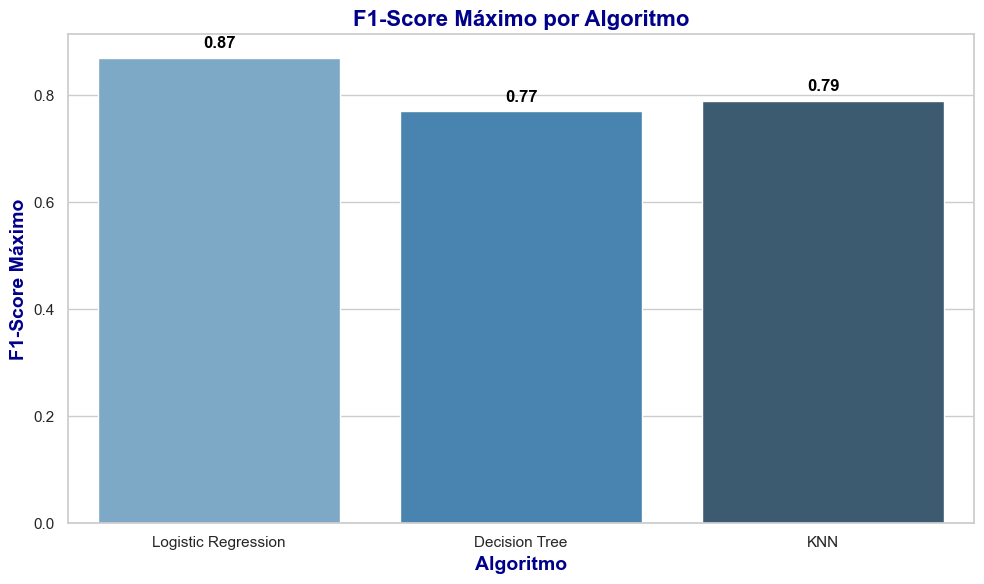

In [189]:

algorithms = ['Logistic Regression', 'Decision Tree', 'KNN']
f1_max = [0.87, 0.77, 0.79]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=algorithms, y=f1_max, palette='Blues_d', hue=algorithms)

plt.title('F1-Score Máximo por Algoritmo', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Algoritmo', fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel('F1-Score Máximo', fontsize=14, fontweight='bold', color='darkblue')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', fontweight='bold', 
                     xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

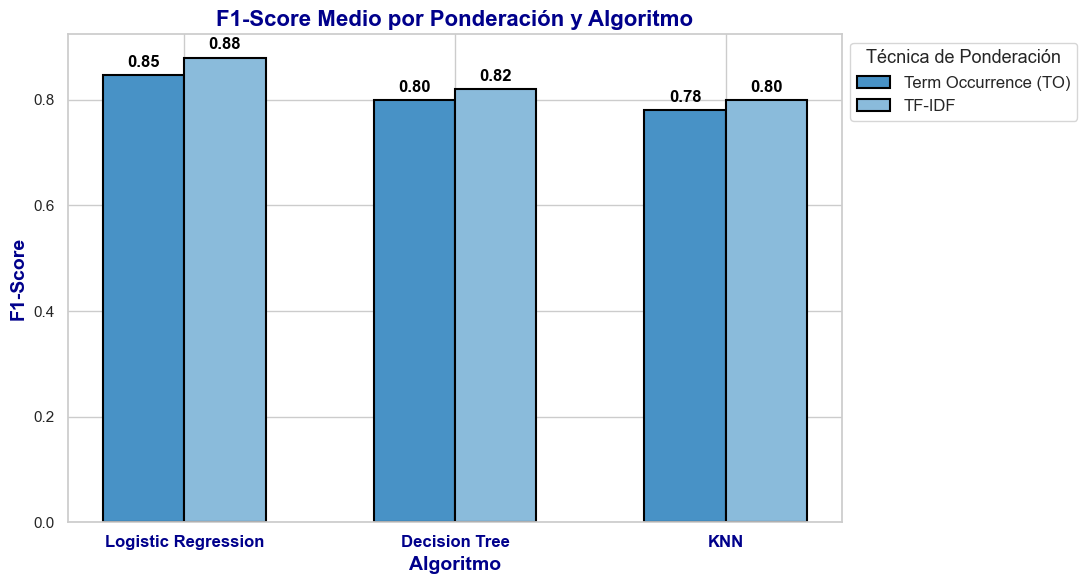

In [198]:
algorithms = ['Logistic Regression', 'Decision Tree', 'KNN']
f1_scores_to = [0.8469, 0.80, 0.78]  
f1_scores_tfidf = [0.88, 0.82, 0.80]  

f1_scores_mean = [np.mean([f1_scores_to[i], f1_scores_tfidf[i]]) for i in range(len(algorithms))] 

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.3 

x = np.arange(len(algorithms))  

ax.bar(x - width/2, f1_scores_to, width, label='Term Occurrence (TO)', color=sns.color_palette("Blues_d")[2], edgecolor='black', linewidth=1.5)
ax.bar(x + width/2, f1_scores_tfidf, width, label='TF-IDF', color=sns.color_palette("Blues_d")[0], edgecolor='black', linewidth=1.5)

ax.set_xlabel('Algoritmo', fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold', color='darkblue')
ax.set_title('F1-Score Medio por Ponderación y Algoritmo', fontsize=16, fontweight='bold', color='darkblue')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, fontsize=12, fontweight='bold', color='darkblue')

ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), title="Técnica de Ponderación", title_fontsize=13)

for i in range(len(algorithms)):
    ax.text(x[i] - width/2, f1_scores_to[i] + 0.01, f'{f1_scores_to[i]:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    ax.text(x[i] + width/2, f1_scores_tfidf[i] + 0.01, f'{f1_scores_tfidf[i]:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()

plt.subplots_adjust(right=0.85)
plt.show()

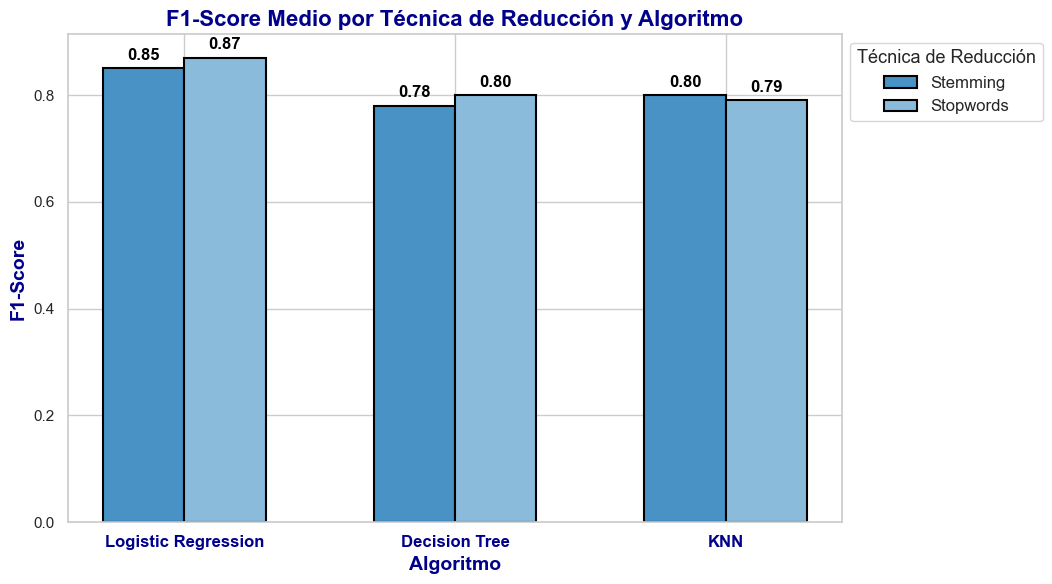

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

algorithms = ['Logistic Regression', 'Decision Tree', 'KNN']
f1_scores_stemming = [0.85, 0.78, 0.80]  
f1_scores_stopwords = [0.87, 0.80, 0.79] 

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.3 

x = np.arange(len(algorithms)) 

ax.bar(x - width/2, f1_scores_stemming, width, label='Stemming', color=sns.color_palette("Blues_d")[2], edgecolor='black', linewidth=1.5)
ax.bar(x + width/2, f1_scores_stopwords, width, label='Stopwords', color=sns.color_palette("Blues_d")[0], edgecolor='black', linewidth=1.5)

ax.set_xlabel('Algoritmo', fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold', color='darkblue')
ax.set_title('F1-Score Medio por Técnica de Reducción y Algoritmo', fontsize=16, fontweight='bold', color='darkblue')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, fontsize=12, fontweight='bold', color='darkblue')

ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), title="Técnica de Reducción", title_fontsize=13)

for i in range(len(algorithms)):
    ax.text(x[i] - width/2, f1_scores_stemming[i] + 0.01, f'{f1_scores_stemming[i]:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    ax.text(x[i] + width/2, f1_scores_stopwords[i] + 0.01, f'{f1_scores_stopwords[i]:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()